In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import pandas as pd
import numpy as np
import imp
import matplotlib.pyplot as plt
import xgboost
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
import seaborn as sns
import scipy.stats as stats
%matplotlib inline
from HelperClass.DataProcessing import *

In [3]:
trainDataFile = 'Data/train.csv'
testDataFile = 'Data/test.csv'
dataTypes = {
    'PassengerId' : 'int64',
    'Survived' : 'int64',
    'Pclass' : 'int64',
    'Name' : 'object',
    'Sex' : 'object',
    'Age' : 'float64',
    'SibSp' : 'int64',
    'Parch' : 'int64',
    'Ticket' : 'object',
    'Fare' : 'float64',
    'Cabin' : 'object',
    'Embarked' : 'object'
}
sep = ','
target = 'Survived'
clusterIdCol = 'PassagerClusterId'
SibSpPlusParchCol = 'SibSp_Plus_Parch'
randomSeed = 83213
testRatio = 0.20
numCores = 7

## 1. Reading data

In [4]:
dataProc = DataProcessing(trainDataFile, dataTypes, sep)
dataProc.ReadFile()
### Here we remove nulls since there were only 2 records that has null in the field
dataProc.AllData = dataProc.AllData[~dataProc.AllData.Embarked.isnull()]
dataProc.AllData = dataProc.AllData[dataProc.AllData.Fare > 0]

submitDataProc = DataProcessing(testDataFile, dataTypes, sep)
submitDataProc.ReadFile()

Findings
1. Age makes difference, F_onewayResult(statistic=4.271194933815904, pvalue=0.03912465401348333)
2. Fare makes difference, F_onewayResult(statistic=63.03076422804448, pvalue=6.120189341921873e-15)
3. PassengerId doesn't make difference, F_onewayResult(statistic=0.022284812266068058, pvalue=0.8813657768798144)
4. Pclass makes difference, F_onewayResult(statistic=115.03127218827665, pvalue=2.5370473879805644e-25)
5. SibSp doesn't make difference, F_onewayResult(statistic=1.110572204113227, pvalue=0.29224392869817906)
6. Parch makes difference, F_onewayResult(statistic=5.963463836603541, pvalue=0.0147992453747224)

### 1.1 Look at each numeric feature and their distribution

In [5]:
def AnalyzeNumericFeature(data, colName):
    notNullData = data[~data[colName].isnull()]
    sns.distplot(notNullData[colName]).set_title(colName)
    plt.show()
    survived = notNullData[notNullData.Survived == 1][colName]
    non_survived = notNullData[notNullData.Survived == 0][colName]
    print(stats.f_oneway(survived, non_survived))

In [6]:
def FeatureBoxplot(data, colName):
    sns.catplot(y=colName, hue=target, kind='count', data=data)
    plt.show()

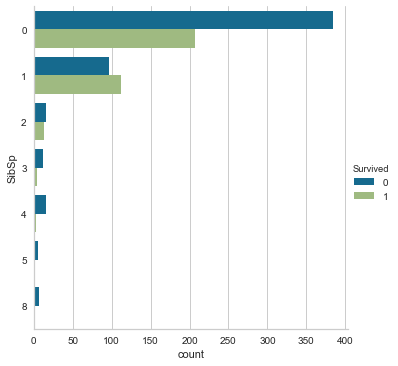

In [7]:
FeatureBoxplot(dataProc.AllData, 'SibSp')

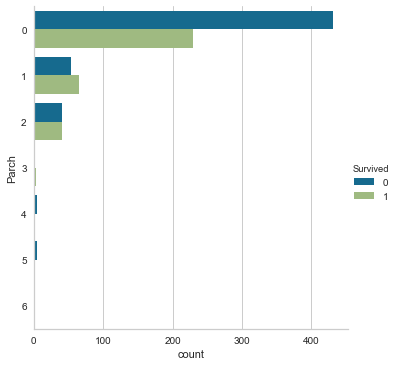

In [8]:
FeatureBoxplot(dataProc.AllData, 'Parch')

In [9]:
##################################################################################################################
##  Create a feature that add two together to see if it's similar pattern to reduce feature columns
##################################################################################################################
dataProc.AllData[SibSpPlusParchCol] = (dataProc.AllData['SibSp'] + dataProc.AllData['Parch']).astype(str)
submitDataProc.AllData[SibSpPlusParchCol] = (submitDataProc.AllData['SibSp'] + 
                                             submitDataProc.AllData['Parch']).astype(str)

In [10]:
dataProc.AllData.groupby([SibSpPlusParchCol])[target].mean().sort_values()

SibSp_Plus_Parch
10    0.000000
7     0.000000
5     0.136364
4     0.200000
0     0.307692
6     0.333333
1     0.552795
2     0.578431
3     0.724138
Name: Survived, dtype: float64

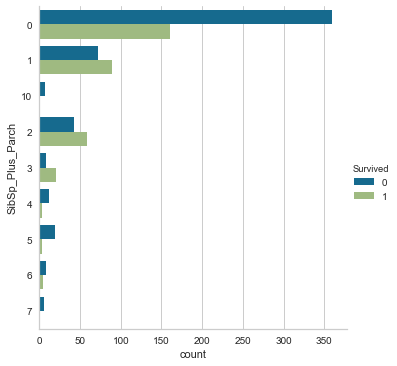

In [11]:
FeatureBoxplot(dataProc.AllData, SibSpPlusParchCol)

In [12]:
## Encoding them into similar survival ratio groups 
SibSpPlusParchMapping = {
    SibSpPlusParchCol : {
        '10' : 1,
        '7' : 1,
        '5' : 2,
        '4' : 2,
        '0' : 3,
        '6' : 3,
        '1' : 4,
        '2' : 4,
        '3' : 5
    }
}

In [13]:
dataProc.AllData.replace(SibSpPlusParchMapping, inplace = True)
submitDataProc.AllData.replace(SibSpPlusParchMapping, inplace = True)

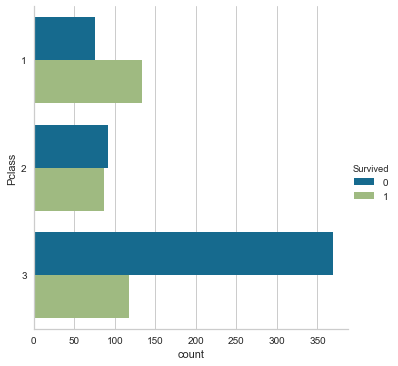

In [14]:
FeatureBoxplot(dataProc.AllData, 'Pclass')

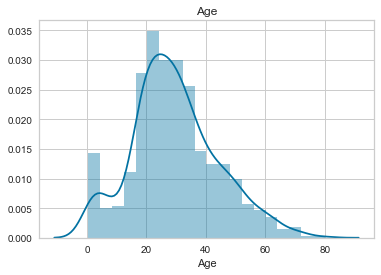

F_onewayResult(statistic=4.410027771674669, pvalue=0.036084033767987425)


In [15]:
AnalyzeNumericFeature(dataProc.AllData, 'Age')

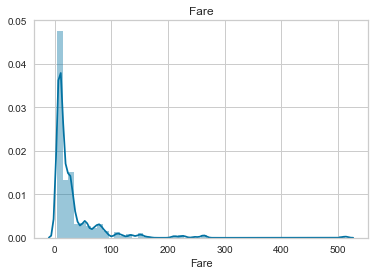

F_onewayResult(statistic=58.354926038452234, pvalue=5.755477902221322e-14)


In [16]:
AnalyzeNumericFeature(dataProc.AllData, 'Fare')

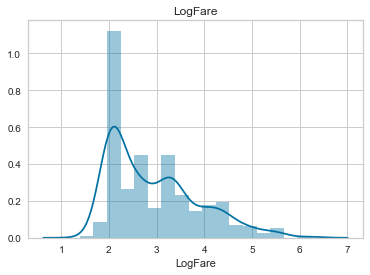

F_onewayResult(statistic=101.21860858322084, pvalue=1.3313831854772286e-22)


In [17]:
### There seems to have some extreme values, take the log 
dataProc.AllData['LogFare'] = np.log(dataProc.AllData['Fare'] + 0.001)
AnalyzeNumericFeature(dataProc.AllData, 'LogFare')

In [18]:
### Not include age group here, due to many na values, engineer some other features to offset it
featureColumns = ['SibSp_Plus_Parch', 'Pclass', 'LogFare']  

### 1.2 Look at each categorical feature and their distribution

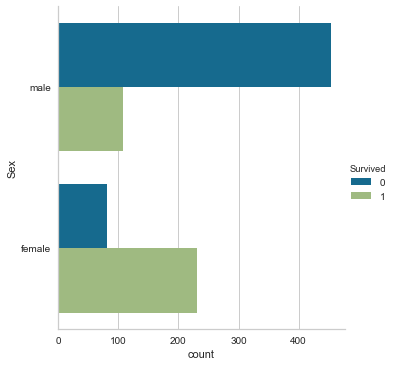

In [19]:
FeatureBoxplot(dataProc.AllData, 'Sex')

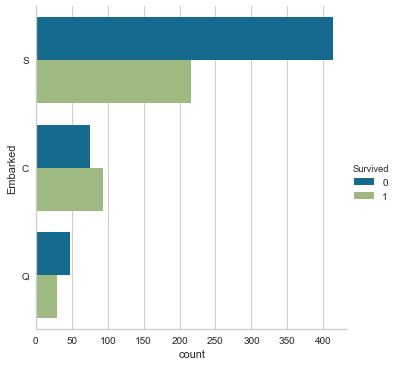

In [20]:
FeatureBoxplot(dataProc.AllData, 'Embarked')

#### Feature generation and encoding for categorical features

In [21]:
def PopulateFeatures(data):
    data.Cabin.fillna('NA', inplace=True)
    data['CabinType'] = data.Cabin.fillna('NA').str.get(0)
    return data

In [22]:
dataProc.AllData = PopulateFeatures(dataProc.AllData)
submitDataProc.AllData = PopulateFeatures(submitDataProc.AllData)

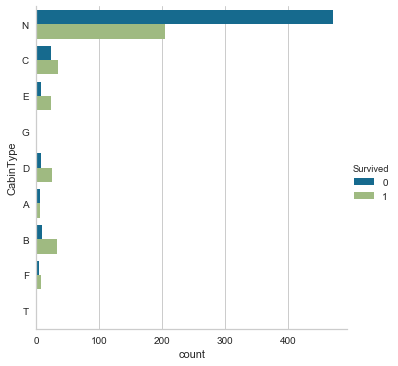

In [23]:
FeatureBoxplot(dataProc.AllData, 'CabinType')

In [24]:
####################################################################################################################
##  It seems cabin type B, D, E has high survival ratio, create an indicator column for these, group others together
####################################################################################################################
dataProc.AllData['CabinType_B_D_E'] = np.where(dataProc.AllData.CabinType.isin(['B', 'D', 'E']), 2, 1)
submitDataProc.AllData['CabinType_B_D_E'] = np.where(submitDataProc.AllData.CabinType.isin(['B', 'D', 'E']), 2, 1)

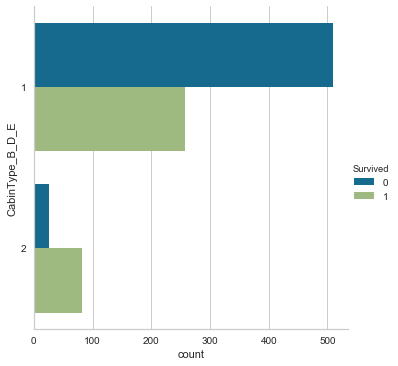

In [25]:
FeatureBoxplot(dataProc.AllData, 'CabinType_B_D_E')

In [26]:
dataProc.AllData.Age.fillna(-999, inplace=True)
submitDataProc.AllData.Age.fillna(-999, inplace=True)

In [27]:
bins = [-10000, 0, 20, 60, 1000]
dataProc.AllData['AgeGroup'] = pd.cut(dataProc.AllData.Age, bins).astype(str)
submitDataProc.AllData['AgeGroup'] = pd.cut(submitDataProc.AllData.Age, bins).astype(str)

In [28]:
dataProc.AllData['GenderAgeGroup'] = dataProc.AllData.Sex + '_' + dataProc.AllData.AgeGroup
submitDataProc.AllData['GenderAgeGroup'] = submitDataProc.AllData.Sex + '_' + submitDataProc.AllData.AgeGroup

In [29]:
dataProc.AllData.groupby(['GenderAgeGroup']).agg({'Survived' : ['mean', 'count']}).sort_values(by=('Survived', 'mean'), 
                                                                                               ascending=False)

Survived      
                        mean count
GenderAgeGroup                    
female_(60, 1000]   1.000000     2
female_(20, 60]     0.777778   180
female_(0, 20]      0.688312    77
female_(-10000, 0]  0.679245    53
male_(0, 20]        0.287129   101
male_(20, 60]       0.187117   326
male_(-10000, 0]    0.137931   116
male_(60, 1000]     0.105263    19

In [30]:
genderAgeGroups = {
    'GenderAgeGroup' : {
        'female_(20, 60]' : 7, 
        'female_(60, 1000]' : 8,
        'female_(0, 20]' : 6, 
        'female_(-10000, 0]' : 5,
        'male_(0, 20]' : 4, 
        'male_(20, 60]' : 3, 
        'male_(-10000, 0]' : 2, 
        'male_(60, 1000]' : 1
    }
}

In [31]:
dataProc.AllData.replace(genderAgeGroups, inplace=True)
submitDataProc.AllData.replace(genderAgeGroups, inplace=True)

In [32]:
genderGroups = {
    'Sex' : {
        'male' : 1,
        'female' : 2
    }
}

In [33]:
dataProc.AllData.replace(genderGroups, inplace=True)
submitDataProc.AllData.replace(genderGroups, inplace=True)

In [34]:
embarkedEncoding = {
    'Embarked' : {
       'S' : 1,
       'Q' : 1,
       'C' : 2
    }
}

In [35]:
dataProc.AllData.replace(embarkedEncoding, inplace=True)
submitDataProc.AllData.replace(embarkedEncoding, inplace=True)

In [36]:
featureColumns = featureColumns + ['CabinType_B_D_E', 'Sex', 'Embarked', 'GenderAgeGroup']

In [37]:
featureColumns

['SibSp_Plus_Parch',
 'Pclass',
 'LogFare',
 'CabinType_B_D_E',
 'Sex',
 'Embarked',
 'GenderAgeGroup']

## Use clustering approach to group passagers

In [38]:
columnsToFindCluster = ['Pclass', 'GenderAgeGroup', 'SibSp_Plus_Parch']

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
trainingCopy = dataProc.AllData[columnsToFindCluster]
trainingCopy = scaler.fit_transform(trainingCopy)
submitDataCopy = scaler.transform(submitDataProc.AllData[columnsToFindCluster])

In [40]:
trainingCopy[:, 0] = trainingCopy[:, 0] * 10
trainingCopy[:, 1] = trainingCopy[:, 1] * 5
trainingCopy[:, 2] = trainingCopy[:, 2]  

submitDataCopy[:, 0] = submitDataCopy[:, 0] * 10
submitDataCopy[:, 1] = submitDataCopy[:, 1] * 5
submitDataCopy[:, 2] = submitDataCopy[:, 2]

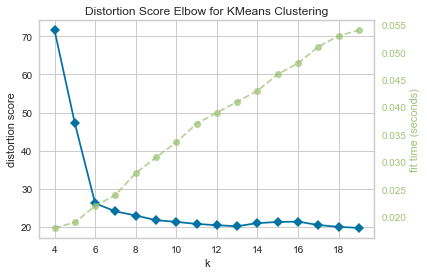

In [41]:
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(4,20))
visualizer.fit(trainingCopy) 
visualizer.poof()

In [42]:
kmeans = KMeans(n_clusters=6, random_state=randomSeed).fit(trainingCopy)

In [43]:
featureColumns.append(clusterIdCol)

In [44]:
dataProc.AllData[clusterIdCol] = kmeans.labels_.astype(str)
submitDataProc.AllData[clusterIdCol] = kmeans.predict(submitDataCopy).astype(str)

In [45]:
dataProc.AllData.groupby([clusterIdCol])[target].mean().sort_values()

PassagerClusterId
5    0.134111
4    0.166667
3    0.384615
1    0.500000
2    0.921053
0    0.967391
Name: Survived, dtype: float64

In [46]:
submitDataProc.AllData[submitDataProc.AllData.Fare.isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SibSp_Plus_Parch,CabinType,CabinType_B_D_E,AgeGroup,GenderAgeGroup,PassagerClusterId
152,1044,3,"Storey, Mr. Thomas",1,60.5,0,0,3701,NaN,NA,1,3,N,1,"(60, 1000]",1,5


In [47]:
averageFare = submitDataProc.AllData[submitDataProc.AllData.PassagerClusterId == '5'].Fare.mean()
submitDataProc.AllData.Fare.fillna(averageFare, inplace=True)
submitDataProc.AllData['LogFare'] = np.log(submitDataProc.AllData['Fare'] + 0.001)

In [48]:
clusterMapping = {
    clusterIdCol : {
        '5' : 1,
        '4' : 1,
        '3' : 2,
        '1' : 3,
        '2' : 4,
        '0' : 4,
    }
}

In [49]:
dataProc.AllData.replace(clusterMapping, inplace=True)
submitDataProc.AllData.replace(clusterMapping, inplace=True)

In [50]:
dataProc.PopulateFeatureColumns(featureColumns)
submitDataProc.PopulateFeatureColumns(featureColumns)

In [51]:
dataProc.y = dataProc.AllData[target]

In [52]:
dataProc.RandomSplitTrainTestData(testRatio, randomSeed, True)

In [53]:
preProc = ColumnTransformer([
    ('StdScaler', StandardScaler(), featureColumns)
])

## Random forest model

In [54]:
rf = RandomForestClassifier(random_state = randomSeed)
rfpipeline = Pipeline([('preProc', preProc),
                       ('poly', PolynomialFeatures()),
                       #('ReduceDim', SelectKBest(f_classif)),
                       ('rf', rf)])
params = {
    'poly__degree' : [1, 2],
    'rf__n_estimators' : range(10, 20),
    'rf__max_depth' : range(1, 5),
    'rf__max_features' : ['sqrt', 'log2', None]
}
rfcv = RandomizedSearchCV(rfpipeline, n_iter= 180, scoring = 'accuracy', n_jobs=numCores, 
                          param_distributions=params, verbose=1, cv = 10, random_state=randomSeed)

In [55]:
#rfcv.fit(dataProc.X_train, dataProc.y_train)

In [56]:
#rfcv.best_params_

In [57]:
#y_train_stacking_pred = rfcv.predict(dataProc.X_train)
#print('Training %.3f ' % accuracy_score(dataProc.y_train, y_train_stacking_pred))
#
#y_test_stacking_pred = rfcv.predict(dataProc.X_test)
#print('Test %.3f ' % accuracy_score(dataProc.y_test, y_test_stacking_pred))

## XGB model

In [58]:
param_grid = {
    'poly__degree' : [1, 2],
    'xgb__max_depth' : [3, 4, 5, 6],
    'xgb__learning_rate' : [0.05, 0.1, 0.2],
    'xgb__n_estimators' : range(5, 21),
    'xgb__subsample' : [0.8, 0.9, 0.95],
    'xgb__colsample_bytree' : [0.8, 0.9, 0.95],
    'xgb__reg_alpha' : [0.05, 0.1, 0.2, 0.4],
    'xgb__reg_lambda' : [0.05, 0.1, 0.2, 0.4],
    'xgb__gamma' : [0.0001, 0.001, 0.01, 0.1]
}

xgb = xgboost.XGBClassifier(seed=randomSeed)
xgbpipeline = Pipeline([('preProc', preProc),
                        ('poly', PolynomialFeatures()),
                        ('xgb', xgb)])
xgbcv = RandomizedSearchCV(xgbpipeline, n_iter = 200, cv=10, param_distributions =param_grid, n_jobs=numCores,
                           scoring='accuracy', verbose = 1, random_state=randomSeed)

In [59]:
#xgbcv.fit(dataProc.X_train, dataProc.y_train)

In [60]:
#xgbcv.best_params_

In [61]:
#y_train_stacking_pred = xgbcv.predict(dataProc.X_train)
#print('Training %.3f ' % accuracy_score(dataProc.y_train, y_train_stacking_pred))
#
#y_test_stacking_pred = xgbcv.predict(dataProc.X_test)
#print('Test %.3f ' % accuracy_score(dataProc.y_test, y_test_stacking_pred))

## AdaBoost

In [62]:
from sklearn.ensemble import AdaBoostClassifier
param_grid = {
    'ada__learning_rate' : [0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8],
    'ada__n_estimators' : range(5, 150)
}
ada = AdaBoostClassifier(random_state=randomSeed)
adapipeline = Pipeline([('ada', ada)])
adacv = RandomizedSearchCV(adapipeline, n_iter = 220, cv=10, param_distributions =param_grid,
                           scoring='accuracy', verbose = 1, random_state=randomSeed)

In [63]:
#adacv.fit(dataProc.X_train, dataProc.y_train)

In [64]:
#adacv.best_params_

In [65]:
#y_train_stacking_pred = adacv.predict(dataProc.X_train)
#print('Training %.3f ' % accuracy_score(dataProc.y_train, y_train_stacking_pred))
#
#y_test_stacking_pred = adacv.predict(dataProc.X_test)
#print('Test %.3f ' % accuracy_score(dataProc.y_test, y_test_stacking_pred))

## Logistic regression

In [66]:
from sklearn import linear_model
param_grid = {
    'poly__degree' : [1, 2],
    'lr__penalty' : ['l1', 'l2'],
    'lr__C' : np.logspace(0, 4, 6)
}

logistic = linear_model.LogisticRegression()
logisticPipeline = Pipeline([('poly', PolynomialFeatures()), 
                             ('lr', logistic)])
logisticCV = GridSearchCV(logisticPipeline, param_grid, cv=10, verbose=1, n_jobs = numCores, scoring='accuracy') 

In [67]:
#logisticCV.fit(dataProc.X_train, dataProc.y_train)

In [68]:
#logisticCV.best_params_

In [69]:
#y_train_stacking_pred = logisticCV.predict(dataProc.X_train)
#print('Training %.3f ' % accuracy_score(dataProc.y_train, y_train_stacking_pred))
#
#y_test_stacking_pred = logisticCV.predict(dataProc.X_test)
#print('Test %.3f ' % accuracy_score(dataProc.y_test, y_test_stacking_pred))

## SVC 

In [70]:
svc = SVC(gamma='auto', random_state = randomSeed)
param_grid = {
    'C' : [1, 2, 4, 8],
    'shrinking' : [True, False]
}
svcCV = GridSearchCV(svc, param_grid, cv=30, verbose=1, n_jobs = numCores, scoring='accuracy') 

In [71]:
#svcCV.fit(dataProc.X_train, dataProc.y_train)

In [72]:
#y_train_stacking_pred = svcCV.predict(dataProc.X_train)
#print('Training %.3f ' % accuracy_score(dataProc.y_train, y_train_stacking_pred))
#
#y_test_stacking_pred = svcCV.predict(dataProc.X_test)
#print('Test %.3f ' % accuracy_score(dataProc.y_test, y_test_stacking_pred))

## Model stacking

In [73]:
from mlens.ensemble import SuperLearner
ensemble = SuperLearner(scorer=accuracy_score, random_state=randomSeed, folds = 3, verbose = 1, n_jobs = numCores)
estimators = [rfcv, xgbcv, logisticCV, adacv]
ensemble.add(estimators, proba=True)
ensemble.add_meta(svc)

[MLENS] backend: threading


SuperLearner(array_check=None, backend=None, folds=3,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=4761, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=3, raise_on_ex...CF0E620>)],
   n_jobs=-1, name='group-1', raise_on_exception=True, transformers=[])],
   verbose=0)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=83213, sample_size=20,
       scorer=<function accuracy_score at 0x00000205ECF0E620>,
       shuffle=False, verbose=1)

In [74]:
ensemble.fit(dataProc.X_train, dataProc.y_train)


Fitting 2 layers
Fitting 10 folds for each of 24 candidates, totalling 240 fitsFitting 10 folds for each of 24 candidates, totalling 240 fits
Fitting 10 folds for each of 24 candidates, totalling 240 fits
Fitting 10 folds for each of 180 candidates, totalling 1800 fits

Fitting 10 folds for each of 180 candidates, totalling 1800 fitsFitting 10 folds for each of 180 candidates, totalling 1800 fits
Fitting 10 folds for each of 24 candidates, totalling 240 fits



[Parallel(n_jobs=7)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=7)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=7)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=7)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=7)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=7)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=7)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=7)]: Done 240 out of 240 | elapsed:  1.6min finished


Fitting 10 folds for each of 180 candidates, totalling 1800 fits


[Parallel(n_jobs=7)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=7)]: Done 240 out of 240 | elapsed:  1.6min finished


Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=7)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=7)]: Done 240 out of 240 | elapsed:  1.7min finished
[Parallel(n_jobs=7)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=7)]: Done 240 out of 240 | elapsed:  2.2min finished


Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=7)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=7)]: Done 1800 out of 1800 | elapsed:  4.2min finished


Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=7)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=7)]: Done 1800 out of 1800 | elapsed:  4.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 220 candidates, totalling 2200 fits


[Parallel(n_jobs=7)]: Done 2000 out of 2000 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 220 candidates, totalling 2200 fits


[Parallel(n_jobs=7)]: Done 2000 out of 2000 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 220 candidates, totalling 2200 fits


[Parallel(n_jobs=7)]: Done 2000 out of 2000 | elapsed:  3.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 220 candidates, totalling 2200 fits


[Parallel(n_jobs=7)]: Done 1800 out of 1800 | elapsed:  6.4min finished
[Parallel(n_jobs=7)]: Done 2000 out of 2000 | elapsed:  2.3min finished
[Parallel(n_jobs=7)]: Done 1800 out of 1800 | elapsed:  5.2min finished
[Parallel(n_jobs=1)]: Done 2200 out of 2200 | elapsed: 14.4min finished
[Parallel(n_jobs=1)]: Done 2200 out of 2200 | elapsed: 14.0min finished
[Parallel(n_jobs=1)]: Done 2200 out of 2200 | elapsed: 13.8min finished


Fit complete                        | 00:20:26


[Parallel(n_jobs=1)]: Done 2200 out of 2200 | elapsed: 16.1min finished


SuperLearner(array_check=None, backend=None, folds=3,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=4761, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=3, raise_on_ex...CF0E620>)],
   n_jobs=-1, name='group-1', raise_on_exception=True, transformers=[])],
   verbose=0)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=83213, sample_size=20,
       scorer=<function accuracy_score at 0x00000205ECF0E620>,
       shuffle=False, verbose=1)

In [75]:
y_train_stacking_pred = ensemble.predict(dataProc.X_train)
print('Training %.3f ' % accuracy_score(dataProc.y_train, y_train_stacking_pred))


Predicting 2 layers
Predict complete                    | 00:00:00
Training 0.861 


In [76]:
y_test_stacking_pred = ensemble.predict(dataProc.X_test)
print('Test %.3f ' % accuracy_score(dataProc.y_test, y_test_stacking_pred))


Predicting 2 layers
Predict complete                    | 00:00:00
Test 0.794 


In [77]:
submitDataProc.AllData[target] = ensemble.predict(submitDataProc.X).astype('int')
submitDataProc.AllData[['PassengerId', 'Survived']].to_csv('submit.txt', index=False)


Predicting 2 layers
Predict complete                    | 00:00:00
